# Exploring COVID-19 Data through Modeling

In this project, I will investigate COVID-19 data over the past year. This data contains information about COVID-19 case counts, mortalities, vaccination rates, and various other metadata that can assist in modeling various aspects of COVID-19.

Through this project, I will demonstrate my experience with:
* Data cleaning and EDA using Pandas
* Unsupervised and supervised learning techniques
* Visualization

## Goal

Model and analyze the temporal evolution of COVID-19 mortalities or cases using one unsupervised and one supervised technique. Interpret the models' results through visualizations, and draw insightful conclusions about the modeling of COVID-19 data.

<!-- Recall that we studied linear and logistic regression, decision trees, random forests as part of supervised learning (with labels) and clustering, PCA as part of unsupervised learning (without labels). You are free to use any methods that you find suitable to answer the problem at hand. -->

In [1]:
# Run this cell to set up your notebook
import numpy as np
from geopy import *
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.cluster import *
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cdist

import warnings
warnings.filterwarnings("ignore")

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from scipy.stats import pearsonr
import re

cases = pd.read_csv('data/time_series_covid19_confirmed_US.csv') 
vaccinations = pd.read_csv('data/people_vaccinated_us_timeline.csv')
counties = pd.read_csv('data/co-est2020.csv', encoding='latin-1') 
mask_use = pd.read_csv('data/mask-use-by-county.csv')

In [2]:
vaccinations

,FIPS,Province_State,Country_Region,Date,Lat,Long_,Combined_Key,People_Fully_Vaccinated,People_Partially_Vaccinated
0,1.0,Alabama,US,2020-12-10,32.3182,-86.9023,"Alabama, US",NaN,NaN
1,1.0,Alabama,US,2020-12-11,32.3182,-86.9023,"Alabama, US",NaN,NaN
2,1.0,Alabama,US,2020-12-12,32.3182,-86.9023,"Alabama, US",NaN,NaN
3,1.0,Alabama,US,2020-12-13,32.3182,-86.9023,"Alabama, US",NaN,NaN
4,1.0,Alabama,US,2020-12-14,32.3182,-86.9023,"Alabama, US",NaN,NaN
...,...,...,...,...,...,...,...,...,...
17746,56.0,Wyoming,US,2021-09-22,42.7560,-107.3025,"Wyoming, US",236785.0,40039.0
17747,56.0,Wyoming,US,2021-09-23,42.7560,-107.3025,"Wyoming, US",237374.0,40011.0
17748,56.0,Wyoming,US,2021-09-24,42.7560,-107.3025,"Wyoming, US",237495.0,40023.0
17749,56.0,Wyoming,US,2021-09-25,42.7560,-107.3025,"Wyoming, US",238024.0,40002.0


<!-- END QUESTION -->



<br/><br/><br/>

---

<br/><br/><br/>

## Data Cleaning

### Missing or Null Values

##### Investigate the number of missing or null values in `cases` and `vaccinations`. Which one column contains the *most* null values from both of these tables?

In [3]:
max(cases.isna().sum()), max(vaccinations.isna().sum())

(10, 3020)

In [4]:
# use argmax() to get the index of the maximum value
most_null_value_col = vaccinations.columns[vaccinations.isna().sum().argmax()]
most_null_value_col

'People_Partially_Vaccinated'

##### Impute the null values in *all* the datasets with zero values or empty strings where appropriate.

In [5]:
nan_indices = cases.columns[cases.isna().any()]
cases[nan_indices].head()      # FIPS -> 0; Admin2 -> ''

,FIPS,Admin2
0,1001.0,Autauga
1,1003.0,Baldwin
2,1005.0,Barbour
3,1007.0,Bibb
4,1009.0,Blount


In [6]:
nan_indices = vaccinations.columns[vaccinations.isna().any()]
vaccinations[nan_indices].head()        # all -> 0

,FIPS,Lat,Long_,People_Fully_Vaccinated,People_Partially_Vaccinated
0,1.0,32.3182,-86.9023,NaN,NaN
1,1.0,32.3182,-86.9023,NaN,NaN
2,1.0,32.3182,-86.9023,NaN,NaN
3,1.0,32.3182,-86.9023,NaN,NaN
4,1.0,32.3182,-86.9023,NaN,NaN


In [7]:
cases['FIPS'] = cases['FIPS'].fillna(0)
cases['Admin2'] = cases['Admin2'].fillna('')
vaccinations = vaccinations.fillna(0)

### Add column

##### Add a column to `cases` named `median_increase` that describes the median daily increase in the number of cases over the time period January 23, 2020 to September 12, 2021. In other words, calculate the increase in cases day-to-day from January 22nd to 23rd, 23rd to 24th, 24th to 25th, and so on; then, find the median of the number of increase in cases over that time period for all counties.

In [8]:
cases.columns[:20]

Index(['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Province_State',
       'Country_Region', 'Lat', 'Long_', 'Combined_Key', '1/22/20', '1/23/20',
       '1/24/20', '1/25/20', '1/26/20', '1/27/20', '1/28/20', '1/29/20',
       '1/30/20'],
      dtype='object')

In [9]:
t1 = cases.loc[:, '1/22/20':'9/11/21']
t2 = cases.loc[:, '1/23/20':'9/12/21']
cases['median_increase'] = np.median(t2.to_numpy() - t1.to_numpy(), axis = 1)

##### Generate a valid FIPS code for the `counties` table.

Refer to [this](https://transition.fcc.gov/oet/info/maps/census/fips/fips.txt) guide on FIPS codes.

State-level FIPS codes have two digits, county-level FIPS codes have five digits of which the first two are the FIPS code of the state to which the county belongs.  When using the list below to look up county FIPS codes, it is advisable to first look up the FIPS code for the state to which the county belongs. **Then we can use this rule to generate `FIPS`**

In [10]:
counties['FIPS'] = counties['STATE'].astype(str).str.zfill(2) + counties['COUNTY'].astype(str).str.zfill(3)
counties['FIPS'] = counties['FIPS'].astype(int)

### Merge tables

##### Merge the `counties`, `cases`, and `mask_use` tables on an appropriate primary key to generate county-wise data.

In [11]:
counties.columns

Index(['SUMLEV', 'REGION', 'DIVISION', 'STATE', 'COUNTY', 'STNAME', 'CTYNAME',
       'CENSUS2010POP', 'ESTIMATESBASE2010', 'POPESTIMATE2010',
       'POPESTIMATE2011', 'POPESTIMATE2012', 'POPESTIMATE2013',
       'POPESTIMATE2014', 'POPESTIMATE2015', 'POPESTIMATE2016',
       'POPESTIMATE2017', 'POPESTIMATE2018', 'POPESTIMATE2019',
       'POPESTIMATE042020', 'POPESTIMATE2020', 'FIPS'],
      dtype='object')

In [12]:
cases.columns

Index(['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Province_State',
       'Country_Region', 'Lat', 'Long_',
       ...
       '9/4/21', '9/5/21', '9/6/21', '9/7/21', '9/8/21', '9/9/21', '9/10/21',
       '9/11/21', '9/12/21', 'median_increase'],
      dtype='object', length=612)

In [13]:
mask_use.columns

Index(['COUNTYFP', 'NEVER', 'RARELY', 'SOMETIMES', 'FREQUENTLY', 'ALWAYS'], dtype='object')

In [14]:
mask_use.describe()

,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
count,3142.000000,3142.000000,3142.000000,3142.000000,3142.000000,3142.000000
mean,30383.649268,0.079940,0.082919,0.121318,0.207725,0.508094
std,15162.508374,0.058538,0.055464,0.058011,0.063571,0.152191
min,1001.000000,0.000000,0.000000,0.001000,0.029000,0.115000
25%,18177.500000,0.034000,0.040000,0.079000,0.164000,0.393250
50%,29176.000000,0.068000,0.073000,0.115000,0.204000,0.497000
75%,45080.500000,0.113000,0.115000,0.156000,0.247000,0.613750
max,56045.000000,0.432000,0.384000,0.422000,0.549000,0.889000


In [15]:
county_data = pd.merge(
    left = counties,
    right = cases,
    left_on = 'FIPS',
    right_on = 'FIPS'
)

county_data = pd.merge(
    left = county_data,
    right = mask_use,
    left_on = 'FIPS',
    right_on = 'COUNTYFP'
)

county_data.shape

(3141, 639)

<!-- BEGIN QUESTION -->

##### Generate the population by state using `counties` using the population estimate in 2020 (i.e. `POPESTIMATE2020`).

In [16]:
counties.groupby('STNAME').sum()['POPESTIMATE2020']

STNAME
Alabama                  9843064
Alaska                   1462316
Arizona                 14842802
Arkansas                 6061044
California              78736156
Colorado                11615438
Connecticut              7114012
Delaware                 1973618
District of Columbia     1425632
Florida                 43466624
Georgia                 21420034
Hawaii                   2814012
Idaho                    3653826
Illinois                25175060
Indiana                 13509906
Iowa                     6327122
Kansas                   5827610
Kentucky                 8954502
Louisiana                9290636
Maine                    2700282
Maryland                12111604
Massachusetts           13787148
Michigan                19933110
Minnesota               11314684
Mississippi              5933572
Missouri                12303096
Montana                  2161154
Nebraska                 3875104
Nevada                   6276518
New Hampshire            2732550
New

<!-- END QUESTION -->



<br/><br/><br/>

---

<br/><br/><br/>

## EDA


##### Create a visualization that shows the median increase in number of cases for the 50 counties with the greatest median increase over January 23, 2020 to September 12, 2021. Includes the name of state in which each county is located since county names are not necessarily unique.

In [17]:
top50 = county_data.nlargest(50, 'median_increase')
top50['full_name'] = top50['CTYNAME'] + ',' +top50['STNAME']
top50.shape

(50, 640)

In [18]:
top50.head()

,SUMLEV,REGION,DIVISION,STATE,COUNTY,STNAME,CTYNAME,CENSUS2010POP,ESTIMATESBASE2010,POPESTIMATE2010,...,9/11/21,9/12/21,median_increase,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS,full_name
203,50,4,9,6,37,California,Los Angeles County,9818605,9818646,9821647,...,1427817,1427817,1110.0,6037,0.021,0.013,0.049,0.131,0.786,"Los Angeles County,California"
609,50,2,3,17,31,Illinois,Cook County,5194675,5195024,5198977,...,602648,602648,691.0,17031,0.023,0.021,0.072,0.162,0.722,"Cook County,Illinois"
2622,50,3,7,48,201,Texas,Harris County,4092459,4093109,4107542,...,525128,526158,546.0,48201,0.019,0.024,0.069,0.152,0.736,"Harris County,Texas"
361,50,3,5,12,86,Florida,Miami-Dade County,2496435,2498003,2506986,...,649123,649123,529.0,12086,0.032,0.023,0.060,0.128,0.756,"Miami-Dade County,Florida"
102,50,4,8,4,13,Arizona,Maricopa County,3817117,3817371,3825183,...,663073,665118,504.0,4013,0.023,0.025,0.059,0.158,0.734,"Maricopa County,Arizona"


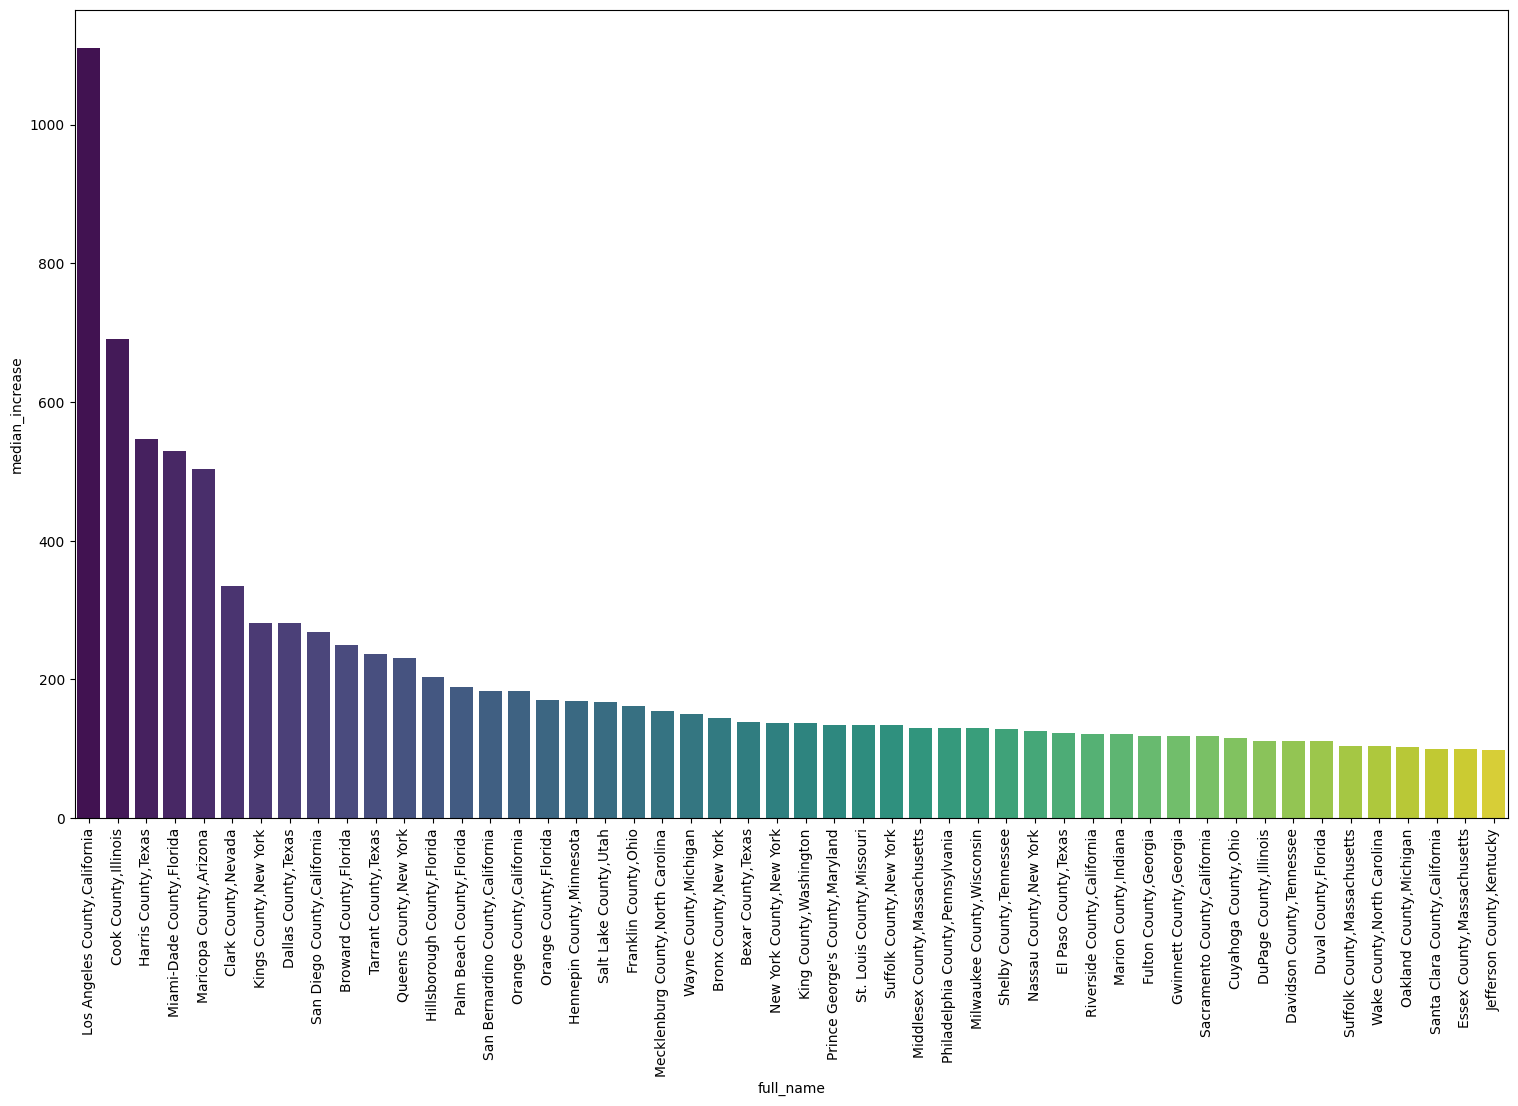

In [19]:
sns.barplot(data = top50, x = 'full_name', y = 'median_increase', palette='viridis')
plt.xticks(rotation=90)


import matplotlib
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5, forward=True)
fig.set_dpi(100);

### Insights
* Los Angeles County, one of the largest counties in the nation, had the greatest median increase in COVID cases fromJanuary 2020 to September 2021 with an increase of over 1,000 cases.

##### Create a visualization that shows the overall state-wise distribution of the number of COVID-19 cases per capita across the United States as a function of time. For all graphs that reference population, use the population estimates from 2020.
<!--
BEGIN QUESTION
name: q2b
points: 4
manual: True
-->

In [20]:
state_wise_county_data = county_data.groupby(['STNAME']).sum()
state_wise_county_data.head()

,SUMLEV,REGION,DIVISION,STATE,COUNTY,CTYNAME,CENSUS2010POP,ESTIMATESBASE2010,POPESTIMATE2010,POPESTIMATE2011,...,9/10/21,9/11/21,9/12/21,median_increase,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
STNAME,,,,,,,,,,,,,,,,,,,,,
Alabama,3350,201,402,67,4489,Autauga CountyBaldwin CountyBarbour CountyBibb...,5457118226527457229155732210914209471185723421...,4780118,4785514,4799642,...,741318,745812,747606,628.0,71489,5.465,5.433,9.823,14.428,31.846
Alaska,1400,112,252,56,4079,Aleutians East BoroughAleutians West Census Ar...,3141556129182617013997182648479758125082150312...,700610,704308,712579,...,93627,93627,93627,42.0,60079,1.559,1.783,2.554,9.463,12.636
Arizona,750,60,120,60,208,Apache CountyCochise CountyCoconino CountyGila...,7151813134613442153597372208437204893817117200...,6392292,6407342,6473416,...,1042480,1045835,1048600,770.0,60208,0.745,0.798,1.420,2.210,9.825
Arkansas,3750,225,525,375,5625,Arkansas CountyAshley CountyBaxter CountyBento...,1901921853415132213393690311508536827446118002...,2916029,2921998,2941038,...,467107,468802,469894,365.0,380625,6.819,6.544,10.377,16.547,34.715
California,2900,232,522,348,3364,Alameda CountyAlpine CountyAmador CountyButte ...,1510271117538091220000455782141910490252861018...,37254522,37319550,37636311,...,4462810,4468496,4472660,2948.0,351364,1.874,1.782,3.694,9.199,41.449


In [21]:
tmp_1 = state_wise_county_data.copy()

# Keep specified date and divide by population to get state wise distribution
tmp_1.loc[:, '1/22/20':'9/12/21'] = tmp_1.loc[:, '1/22/20':'9/12/21'].div(tmp_1['POPESTIMATE2020'],
                                                                              axis = 0)
# Transpose to get per day distribution
tmp_1 = tmp_1.T.loc['1/22/20':'9/12/21', :].reset_index()
tmp_1.tail()

STNAME,index,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
595,9/8/21,0.148765,0.127611,0.139733,0.152629,0.112925,0.108598,0.10582,0.124355,0.079535,...,0.151826,0.155401,0.128353,0.109143,0.04719,0.092357,0.076509,0.112988,0.128432,0.136172
596,9/9/21,0.149652,0.128761,0.140067,0.153423,0.113067,0.108926,0.105994,0.124712,0.079767,...,0.15252,0.156082,0.129193,0.109567,0.047434,0.092817,0.077033,0.113965,0.128791,0.137088
597,9/10/21,0.150627,0.129711,0.140469,0.154134,0.113361,0.109302,0.106169,0.125369,0.079917,...,0.153209,0.156747,0.129857,0.110019,0.04767,0.093338,0.077477,0.115298,0.129267,0.138484
598,9/11/21,0.151541,0.129711,0.140922,0.154693,0.113506,0.109302,0.106169,0.125995,0.079917,...,0.153209,0.156747,0.130157,0.110019,0.047989,0.093338,0.077477,0.116566,0.129267,0.138484
599,9/12/21,0.151905,0.129711,0.141294,0.155054,0.113611,0.109302,0.106169,0.126533,0.079917,...,0.153209,0.156747,0.13024,0.110019,0.048278,0.093338,0.077477,0.117823,0.129267,0.138484


In [22]:
# Rename date column
tmp_1.rename(columns={'index':'Date'}, inplace=True)

# Convert date column to datetime
tmp_1['Date'] = pd.to_datetime(tmp_1['Date'])

# Create columns for month and year
tmp_1['Month'] = tmp_1['Date'].dt.month
tmp_1['Year'] = tmp_1['Date'].dt.year

# Update country columns to int
for col in tmp_1.columns[1:52]:
    tmp_1[col] = pd.to_numeric(tmp_1[col], errors='coerce') 

# Aggregate by month and year
state_wise_cases = tmp_1.groupby(['Year','Month']).sum(numeric_only=True)

# state_wise_cases

In [23]:
# Create a 'Month-Year' column for the x-axis
state_wise_cases['Month-Year'] = state_wise_cases.index.map(lambda x: f"{x[1]:02d}-{x[0]}")  # Format as MM-YYYY

# Melt df
state_cases_long = state_wise_cases.melt(id_vars=['Month-Year'], var_name='State', value_name='Cases_Per_Capita')

state_cases_long

,Month-Year,State,Cases_Per_Capita
0,01-2020,Alabama,0.000000
1,02-2020,Alabama,0.000000
2,03-2020,Alabama,0.001368
3,04-2020,Alabama,0.025902
4,05-2020,Alabama,0.076704
...,...,...,...
1066,05-2021,Wyoming,3.151564
1067,06-2021,Wyoming,3.158636
1068,07-2021,Wyoming,3.383557
1069,08-2021,Wyoming,3.695977


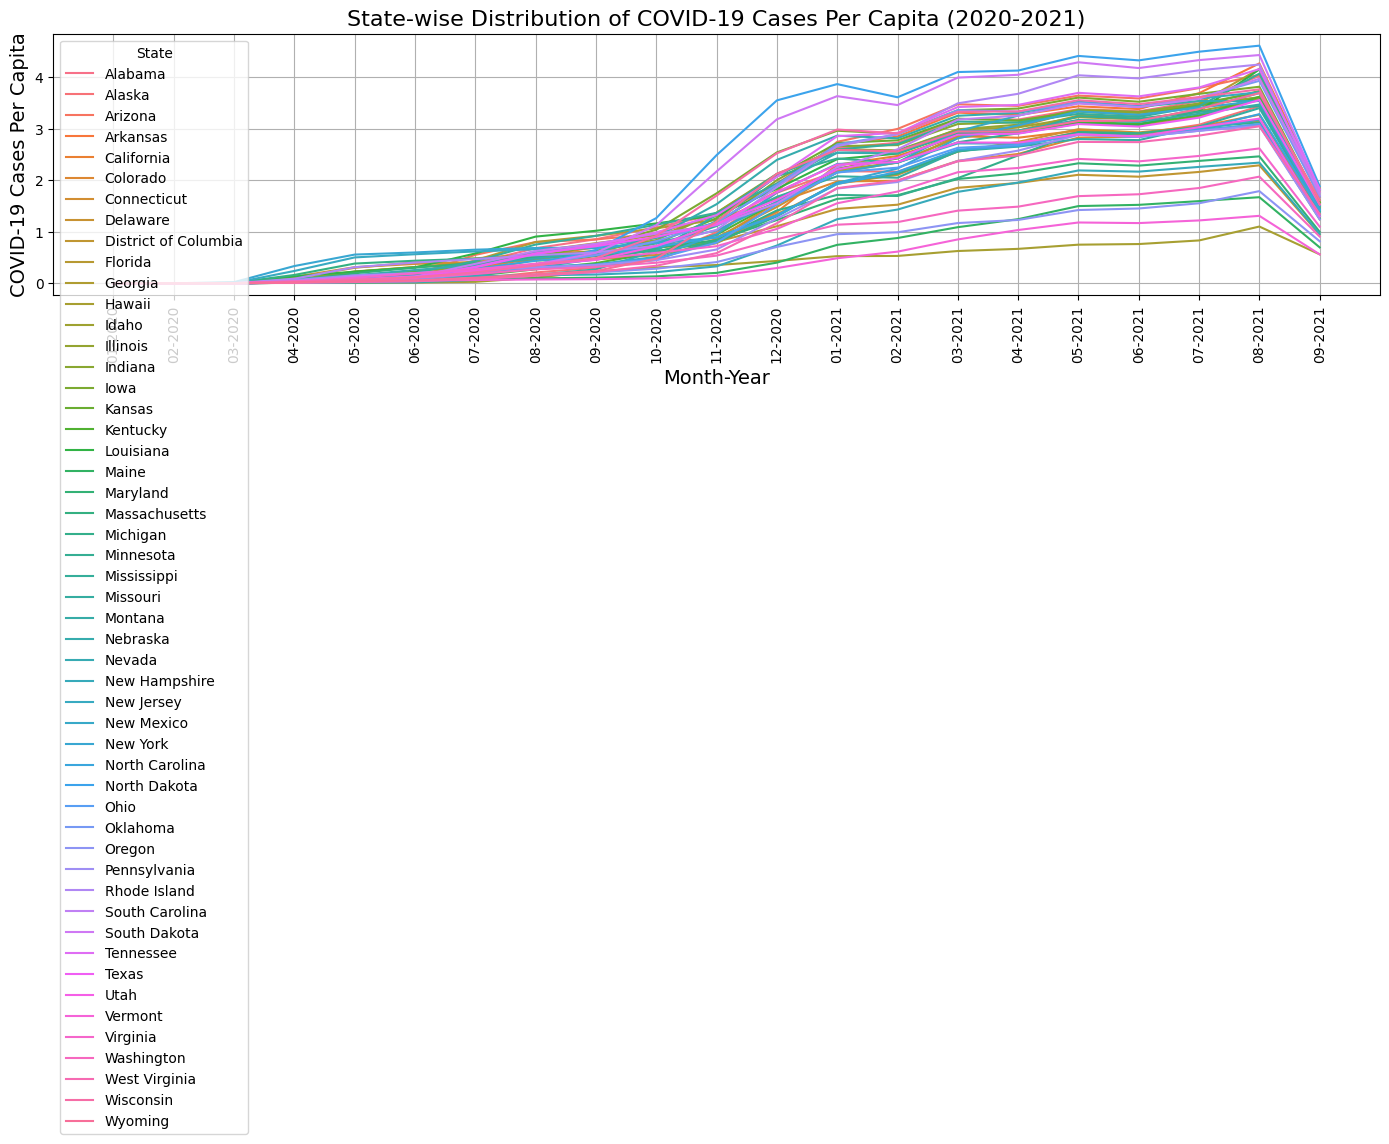

In [24]:
# Plotting the state-wise distribution of COVID-19 cases per capita
plt.figure(figsize=(14, 8))
sns.lineplot(data=state_cases_long, x='Month-Year', y='Cases_Per_Capita', hue='State')

plt.title('State-wise Distribution of COVID-19 Cases Per Capita (2020-2021)', fontsize=16)
plt.xlabel('Month-Year', fontsize=14)
plt.ylabel('COVID-19 Cases Per Capita', fontsize=14)
plt.xticks(rotation=90)
plt.legend(title='State', loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.show()

### Insights
* In nearly all states, covid-19 cases per capita started to increase in December 2020 and declined in August 2021.

##### Create a visualization that shows states' increases in the number of COVID-19 cases per capita from September 3rd to September 12th, sorted from least to greatest increases. 

In [25]:
tmp_2 = state_wise_county_data.loc[:, '9/3/21':'9/12/21'].copy()
tmp_2['Increase count'] = tmp_2['9/12/21'] - tmp_2['9/3/21']
tmp_2 = tmp_2.sort_values(by = 'Increase count')
tmp_2 = tmp_2.reset_index()
tmp_2.head()

,STNAME,9/3/21,9/4/21,9/5/21,9/6/21,9/7/21,9/8/21,9/9/21,9/10/21,9/11/21,9/12/21,Increase count
0,Nebraska,221235,221235,221235,221235,221235,221235,221235,221235,221235,221235,0
1,District of Columbia,55918,55918,55918,55918,56569,56694,56859,56966,56966,56966,1048
2,Vermont,28683,28864,28974,29104,29304,29416,29568,29715,29914,30094,1411
3,Rhode Island,149587,149587,149587,149587,149587,151300,151658,151658,151658,151658,2071
4,New Hampshire,108245,108245,108245,108245,109243,109757,110246,110548,110548,110548,2303


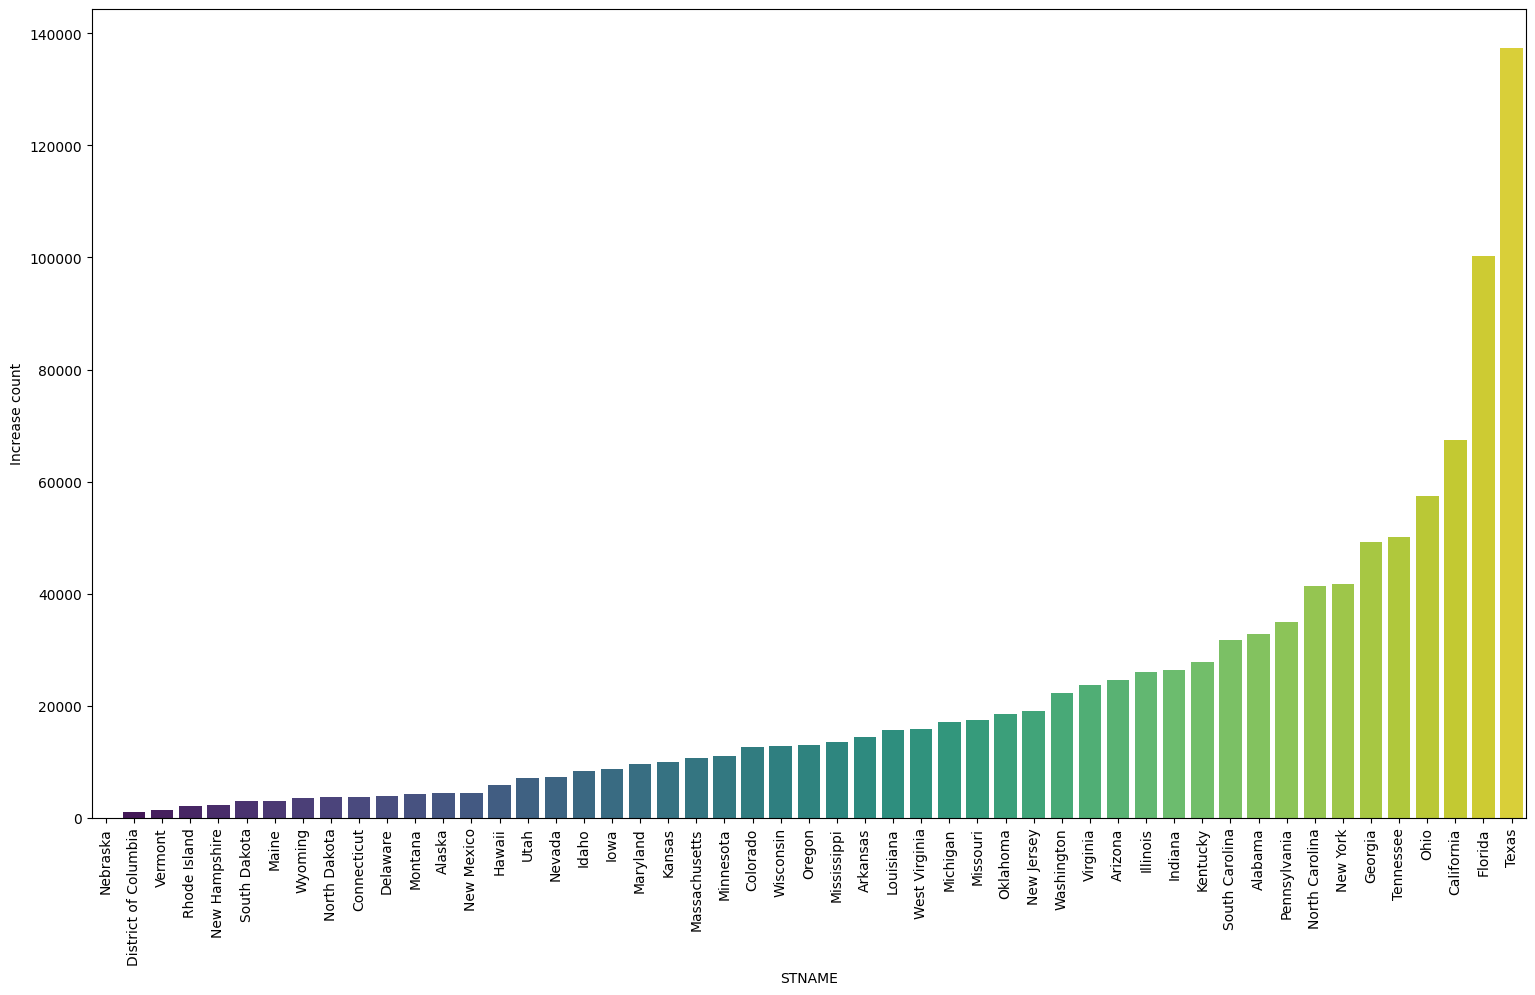

In [26]:
sns.barplot(data = tmp_2, x = 'STNAME', y = 'Increase count', palette='viridis')

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5, forward=True)
fig.set_dpi(100);

plt.xticks(rotation=90);

### Insights
* During September 2021, covid-19 cases had decreased from August 2021. But cases began to increase on 9/3/12 especially for Texas, Florida, and California.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

##### Create a plot that visualizes the relationship between:

The number of COVID-19 cases as a function of time for the Mobile, Tarrant, Cook, and San Fransisco counties located in Alabama, Texas, Illinois, and California.

In [27]:
# 'Cook County' appears in many states
tmp_3 = county_data[county_data['CTYNAME'].isin(['Mobile County','Tarrant County','San Francisco County'])
                     | ((county_data['STNAME'] == 'Illinois') & (county_data['CTYNAME'] == 'Cook County'))].copy()
tmp_3

,SUMLEV,REGION,DIVISION,STATE,COUNTY,STNAME,CTYNAME,CENSUS2010POP,ESTIMATESBASE2010,POPESTIMATE2010,...,9/10/21,9/11/21,9/12/21,median_increase,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
48,50,3,6,1,97,Alabama,Mobile County,412992,413139,413328,...,68382,68791,68902,51.0,1097,0.077,0.070,0.102,0.244,0.506
222,50,4,9,6,75,California,San Francisco County,805235,805184,805519,...,48404,48518,48660,46.0,6075,0.017,0.011,0.035,0.121,0.817
609,50,2,3,17,31,Illinois,Cook County,5194675,5195024,5198977,...,602648,602648,602648,691.0,17031,0.023,0.021,0.072,0.162,0.722
2741,50,3,7,48,439,Texas,Tarrant County,1809034,1811345,1818167,...,319204,319204,319204,237.0,48439,0.023,0.034,0.077,0.144,0.722


In [28]:
tmp_4 = tmp_3.set_index('CTYNAME')
tmp_4 = tmp_4.T.loc['1/22/20':'9/12/21', :]
tmp_4 = tmp_4.rename(columns={'48':'Mobile County', '222':'San Francisco County', '609': 'Cook County', '2741': 'Tarrant County'})
tmp_4.tail()

CTYNAME,Mobile County,San Francisco County,Cook County,Tarrant County
9/8/21,67156,48175,600122,315696
9/9/21,67486,48263,601238,317324
9/10/21,68382,48404,602648,319204
9/11/21,68791,48518,602648,319204
9/12/21,68902,48660,602648,319204


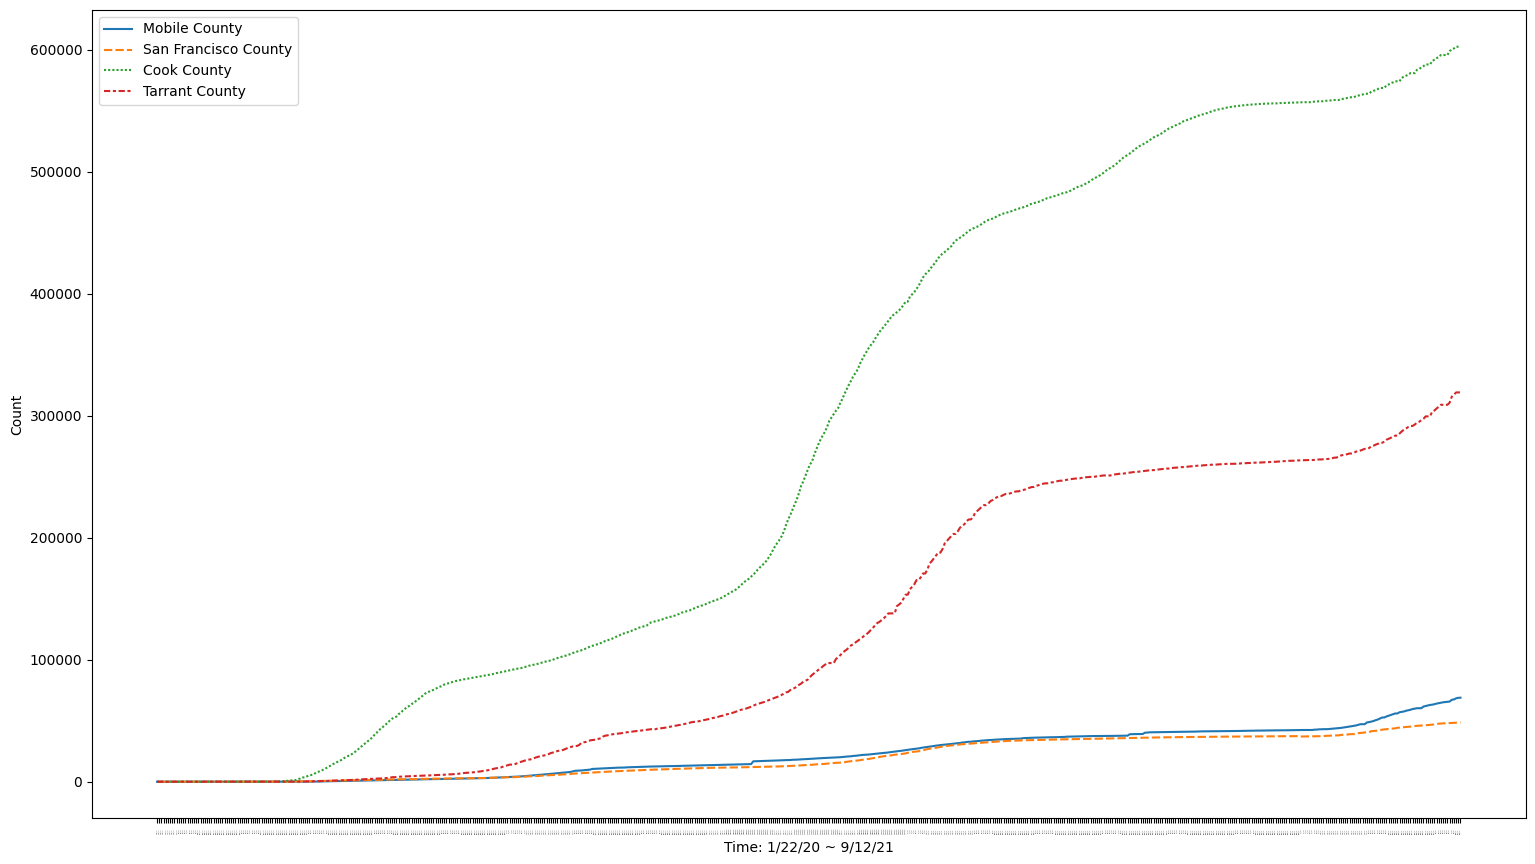

In [29]:
sns.lineplot(data = tmp_4)

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5, forward=True)
fig.set_dpi(100);

plt.xticks(fontsize = 0, rotation = 90)
plt.legend(loc = 'upper left')
plt.ylabel("Count")
plt.xlabel("Time: 1/22/20 ~ 9/12/21");

The frequency of never, rarely or sometimes wearing a mask in the respective counties

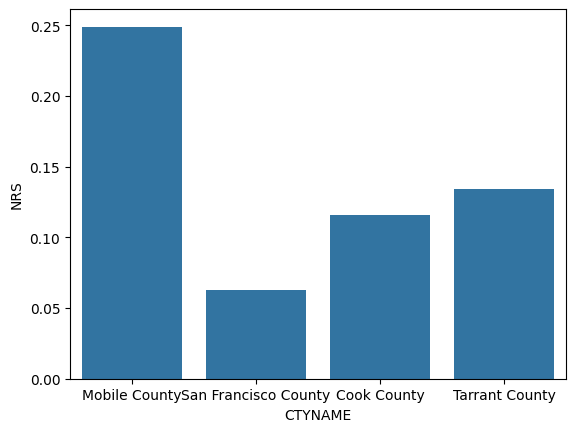

In [30]:
tmp_3['NRS'] = tmp_3['NEVER'] + tmp_3['RARELY'] + tmp_3['SOMETIMES']
sns.barplot(data = tmp_3, x = 'CTYNAME', y = 'NRS');

### Insights
* Even as Cook County, Illinois has the greatest amount of covid-19 cases overtime, people in Cook county wore masks more often than people in San Francisco County which had the least cases over time.
* This might indicate that other factors such as vaccinations might have a greater impact on cases. 

### Vaccinations across the US

##### Visualize and describe the spatial relationship between the location and the following quantities over the continguous United States:

a) the number of most recent COVID-19 cases per capita on September 12, 2021

b) the frequency of never, rarely or sometimes wearing a mask

Use `plotly` to generate a heatmap on a geographical plot of the United States!

In [41]:
# vaccinations.groupby('Province_State').sum
vaccinations
vaccinations_agg = vaccinations.groupby('Province_State').agg(
    Lat=('Lat', 'mean'),
    Long_=('Long_', 'mean'),
    People_Fully_vaccinated=('People_Fully_Vaccinated', 'sum')
).reset_index()
vaccinations_agg

,Province_State,Lat,Long_,People_Fully_Vaccinated
0,Alabama,32.3182,-86.9023,288982578.0
1,Alaska,61.3707,-152.4044,60803712.0
2,American Samoa,-14.2710,-170.1320,4214105.0
3,Arizona,33.7298,-111.4312,564187643.0
4,Arkansas,34.9697,-92.3731,191399883.0
...,...,...,...,...
56,Virginia,37.7693,-78.1700,756610292.0
57,Washington,47.4009,-121.4905,699492702.0
58,West Virginia,38.4912,-80.9545,136835008.0
59,Wisconsin,44.2685,-89.6165,505196237.0


In [45]:
import folium
from folium.plugins import HeatMap

# Create a base map (centered on the US)
m = folium.Map(location=[37.0902, -95.7129], zoom_start=5)

# Prepare data for the heatmap (latitude, longitude, and fully vaccinated count)
heatmap_data = [
    [row['Lat'], row['Long_'], row['People_Fully_Vaccinated']]
    for _, row in vaccinations_agg.iterrows()
    if not pd.isna(row['Lat']) and not pd.isna(row['Long_'])
]

# Add the heatmap to the map
HeatMap(heatmap_data).add_to(m)

# Display the map directly in the notebook
m

# Save the map to an HTML file
m.save('vaccination_heatmap.html')


### Insights
* The highest concentration of people fully vaccinated in the US are along the West and East coasts - states which tend to lean more progressive.

<!-- END QUESTION -->



<br/><br/><br/>

---

<br/><br/><br/>

## Unsupervised Exploration


<!-- BEGIN QUESTION -->

### SVD

Using SVD, decompose the standardized matrix $X$ that contains the standardized current proportion of fully vaccinated and partially vaccinated, cases per capita, and mask usage for every state as of the most recent day in the data.

In [31]:
vaccinations.groupby('Province_State').max().head()

,FIPS,Country_Region,Date,Lat,Long_,Combined_Key,People_Fully_Vaccinated,People_Partially_Vaccinated
Province_State,,,,,,,,
Alabama,1.0,US,2021-09-26,32.3182,-86.9023,"Alabama, US",2069026.0,567613.0
Alaska,2.0,US,2021-09-26,61.3707,-152.4044,"Alaska, US",372964.0,86035.0
American Samoa,60.0,US,2021-09-26,-14.2710,-170.1320,"American Samoa, US",27875.0,8667.0
Arizona,4.0,US,2021-09-26,33.7298,-111.4312,"Arizona, US",3702564.0,964838.0
Arkansas,5.0,US,2021-09-26,34.9697,-92.3731,"Arkansas, US",1367406.0,379154.0


The most recent day: 2021-09-26

In [38]:
tmp_4 = county_data.copy()
tmp_4 = tmp_4[['STATE', '9/12/21', 'NEVER', 'RARELY', 'SOMETIMES', 'FREQUENTLY', 'ALWAYS']]

most_recent_vacc = vaccinations[vaccinations['Date'] == '2021-09-26'][['FIPS',
                                                                       'Province_State',
                                                                       'People_Fully_Vaccinated',
                                                                       'People_Partially_Vaccinated'
                                                                      ]]
# use 'FIPS' to join two tables
tmp_4 = pd.merge(
    left = tmp_4,
    right = most_recent_vacc,
    left_on = 'STATE',
    right_on = 'FIPS'
)

# Create a new dataframe with 51 rows
X = pd.DataFrame(index = county_data['STNAME'].unique())

X['Cases per capita'] = tmp_4.groupby('Province_State').sum()[['9/12/21']].to_numpy()
X['Cases per capita'] /= state_wise_county_data['POPESTIMATE2020']
X[['People_Fully_Vaccinated', 'People_Partially_Vaccinated']] = (tmp_4
                                                                 .groupby('Province_State')
                                                                 .first()[['People_Fully_Vaccinated', 'People_Partially_Vaccinated']])
X[['NEVER', 'RARELY', 'SOMETIMES', 'FREQUENTLY', 'ALWAYS']] = (tmp_4
                                                               .groupby('Province_State')[['NEVER', 'RARELY', 'SOMETIMES', 'FREQUENTLY', 'ALWAYS']]
                                                               .mean())
X = (X - X.mean(axis = 0)) / X.std(axis = 0)

u, s, vt = np.linalg.svd(X, full_matrices = False)

X.head()

,Cases per capita,People_Fully_Vaccinated,People_Partially_Vaccinated,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
Alabama,1.150477,-0.350270,-0.078169,0.285379,0.191601,1.027072,0.408147,-0.511105
Alaska,0.355549,-0.748397,-0.609991,-0.335518,-0.224252,-0.422111,3.217044,-0.670420
Arizona,0.770419,0.033181,0.036478,-0.479704,-0.474527,-0.331797,-1.149766,0.680307
Arkansas,1.263254,-0.514966,-0.306495,0.509692,0.338820,0.811205,0.529175,-0.593633
California,-0.221097,4.739031,5.278886,-0.895968,-1.011352,-1.142145,-0.891600,1.075736


array([1.55406641e+01, 9.55889743e+00, 5.83020341e+00, 4.59463458e+00,
       2.72887654e+00, 1.64141848e+00, 1.36829742e+00, 6.31588897e-03])

### Principle Components

Visualize the top 2 principal components and label the data points with the corresponding location. Color each data points based on the number of cases per capita in the location to which it corresponds.

In [33]:
tmp_4.groupby('Province_State').sum()[['9/12/21']].shape

(51, 1)

In [34]:
(X @ vt.T[:, :2]).reset_index().shape

(51, 3)

In [44]:
pcs = (X @ vt.T[:, :2])
pcs = pd.concat([pcs, tmp_3.groupby('Province_State').sum()[['9/12/21']]], axis = 1)
pcs = pcs.reset_index()
pcs.columns = ['State', 'Pc1', 'Pc2', 'Cases']

pcs.head()

,State,Pc1,Pc2,Cases
0,Alabama,-1.372145,-0.299742,747606
1,Alaska,-1.385786,0.566010,93627
2,Arizona,1.095759,-0.035709,1048600
3,Arkansas,-1.619365,-0.086958,469894
4,California,3.982411,-6.139417,4472660


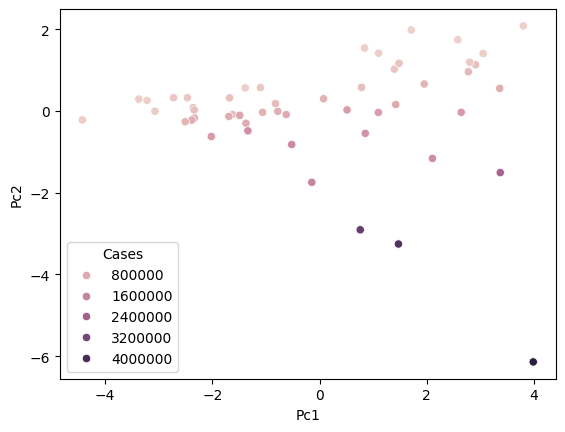

In [45]:
sns.scatterplot(data = pcs, x = 'Pc1', y = 'Pc2', hue = 'Cases');

In [47]:
# Loadings matrix (vt contains the right singular vectors)
loadings = pd.DataFrame(vt.T, index=X.columns, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5',  'PC6', 'PC7','PC8'])

# Sort variables by their contribution to PC1 and PC2
pc1_loadings = loadings['PC1'].sort_values(ascending=False)
pc2_loadings = loadings['PC2'].sort_values(ascending=False)

print("Top variables contributing to PC1:")
print(pc1_loadings)

print("\nTop variables contributing to PC2:")
print(pc2_loadings)

Top variables contributing to PC1:
ALWAYS                         0.448330
People_Fully_Vaccinated        0.191274
People_Partially_Vaccinated    0.174559
Cases per capita              -0.241568
FREQUENTLY                    -0.362634
SOMETIMES                     -0.421316
RARELY                        -0.426277
NEVER                         -0.427628
Name: PC1, dtype: float64

Top variables contributing to PC2:
ALWAYS                         0.085939
RARELY                        -0.039141
NEVER                         -0.076467
FREQUENTLY                    -0.077951
SOMETIMES                     -0.123165
Cases per capita              -0.303614
People_Fully_Vaccinated       -0.653823
People_Partially_Vaccinated   -0.666575
Name: PC2, dtype: float64


### Insights

*Principle components are linear combinations of the original variables.*

**PC1**
> PC1 Captures the contrast between consistent mask usage (positive scores) and low or inconsistent mask usage (negative scores).
States with higher PC1 values are likely characterized by better public health adherence (more mask usage and vaccinations, fewer cases).
- Positive PC1: States with better mask compliance and higher vaccination rates.
- Negative PC1: States with poor mask compliance and higher case rates.

**PC2**
> PC2 primarily represents a vaccination-driven trend, where lower PC2 scores correspond to higher vaccination rates and potentially lower case rates.
- Negative PC2: States with high vaccination rates and potentially better COVID-19 outcomes.
- Positive PC2: States with lower vaccination rates and potentially worse COVID-19 outcomes.

**Key Takeaways:**
* Darker dots (higher case rates) cluster where PC1 is high and PC2 is low. This is because high PC1 corresponds to higher mask usage and higher vaccination rates, while low PC2 reflects lower vaccination rates, which may result in higher case rates.
* Lighter dots (lower case rates) cluster where PC2 is high, indicating thathigher vaccination rates contribute to lower case rates.
* PC1 alone, as suggested by the loadings, is associated with mask usage (especially the "ALWAYS" variable). However, the broad distribution of lighter dots across PC1 suggests that mask usage alone isn't sufficient to explain lower case rates across states. Other factors, such as vaccination rates or public health interventions, likely play a significant role.
* PC2 appears to be strongly associated with vaccination rates, which have a negative loading. Thus, PC2 contributes significantly to the pattern of lower case rates. States with high PC2 likely have higher vaccination rates, which would contribute to lower case rates, regardless of where they fall on PC1.

### Scree Plot

Construct a scree plot displaying the proportion of variance captured by each principal component.

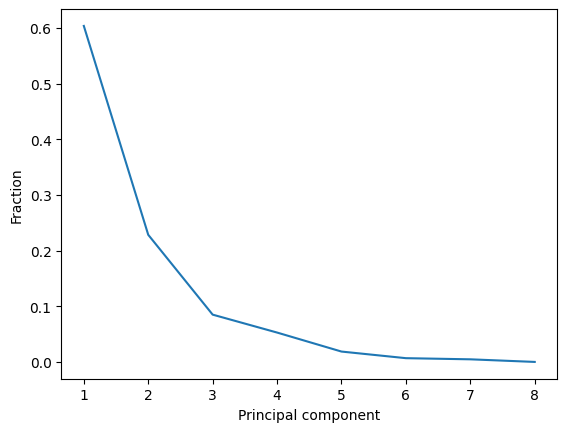

In [53]:
proportion = s ** 2 / np.sum(s ** 2) # explained variance ratio
sns.lineplot(x = np.arange(1, len(s) + 1), y = proportion)
plt.xlabel('Principal component')
plt.ylabel('Fraction');

### Insights
* PC1 and Pc2 are the most useful since they capture most of the variance.  

### PC Neighbors

Using the 2D representation of each state's first two principal components $x_i = [\text{PC}_1, \text{PC}_2]$, find each state's 5 closest principal component neighbors using Euclidean distance as the metric. In other words, for each state $i$ with first two principal components $x_i$, the following would be its *closest* principal component neighbor:

$$
\arg \min_{j \ne i} ||x_j - x_i||_2
$$

Store each state's 5 closest neighbors in a Pandas DataFrame, where the index is the state's name and the columns are the 5 closest PC neighbors.

In [52]:
state_mins = pd.DataFrame(index = pcs['State'], columns = ['1st', '2nd', '3rd', '4th', '5th'])

# matrix[i, j] = the distance between the city i and the city j
matrix = pd.DataFrame(index = pcs['State'], columns = pcs['State'])

M, N = state_mins.shape

for i in range(M):
    for j in range(i + 1, M):
        citya, cityb = pcs['State'][i], pcs['State'][j]
        left = pcs[pcs['State'] == citya][['Pc1', 'Pc2']].to_numpy()
        right = pcs[pcs['State'] == cityb][['Pc1', 'Pc2']].to_numpy()
        matrix.iloc[i, j] = np.linalg.norm(left - right, ord = 2)
        #print(np.linalg.norm(left - right, ord = 2))
        
matrix = matrix.T
        
for i in range(M):
    state_mins.iloc[i, :] = matrix.iloc[:, i].sort_values().index[:5]
    
state_mins.head()

,1st,2nd,3rd,4th,5th
State,,,,,
Alabama,Ohio,Indiana,Arkansas,Wisconsin,Kentucky
Alaska,West Virginia,Utah,Indiana,Kentucky,Mississippi
Arizona,Virginia,North Carolina,Michigan,Nevada,Colorado
Arkansas,Wisconsin,Indiana,Utah,Ohio,Kentucky
California,Texas,Florida,New York,Pennsylvania,Illinois


### Insights
* Based on the first two principle components, these states are the most similar to each other. 

### PC Neighbors for California and Florida

Investigate the principal component neighbors for California and Florida.

In [56]:
# Choose two states of interest (e.g., 'California' and 'New York')
state1 = 'California'
state2 = 'Florida'

# Get the closest principal component neighbors for each state
neighbors_state1 = state_mins.loc[state1].values
neighbors_state2 = state_mins.loc[state2].values

# Print out the neighbors
print(f"Neighbors for {state1}: {neighbors_state1}")
print(f"Neighbors for {state2}: {neighbors_state2}")

# Retrieve the COVID-19 data (cases per capita) for the two states and their neighbors
covid_data = pcs[['State', 'Cases']].set_index('State')

# Get the cases per capita for the two states and their neighbors
covid_state1 = covid_data.loc[[state1] + list(neighbors_state1), 'Cases']
covid_state2 = covid_data.loc[[state2] + list(neighbors_state2), 'Cases']

# Print COVID-19 statistics for each state and their neighbors
print("\nCOVID-19 Cases Per Capita (State1 and its neighbors):")
print(covid_state1)

print("\nCOVID-19 Cases Per Capita (State2 and its neighbors):")
print(covid_state2)

Neighbors for California: ['Texas' 'Florida' 'New York' 'Pennsylvania' 'Illinois']
Neighbors for Florida: ['Texas' 'Illinois' 'Pennsylvania' 'North Carolina' 'Georgia']

COVID-19 Cases Per Capita (State1 and its neighbors):
State
California      4472660
Texas           3823937
Florida         3449738
New York        2335596
Pennsylvania    1346619
Illinois        1564267
Name: Cases, dtype: int64

COVID-19 Cases Per Capita (State2 and its neighbors):
State
Florida           3449738
Texas             3823937
Illinois          1564267
Pennsylvania      1346619
North Carolina    1278739
Georgia           1440779
Name: Cases, dtype: int64


### Insights

* Both California and Florida have high COVID-19 case counts and share common neighbors like Texas, Illinois, and Pennsylvania. The similarity in their pandemic trajectories likely reflects shared characteristics such as population density, mobility, and regional health policies. The shared proximity of these states in principal component space highlights how states with high case numbers (often driven by large populations and varying public health policies) can have similar pandemic profiles despite their political or geographical differences.

### Distance vs Top Two Principle Component Distance!!!

We will investigate the relationship between geographical distance in miles and top two principal component distance between any two unique pairs of states. 

For the sake of simplicity, may assume that the singular geographical location of a state is given by the mean latitude and longitude of all the counties in that state. For each unique pair of states, calculate the geographical distance and the Euclidean distance between their top 2 principal components between them. Plot the relationship where the x-axis represents the top 2 principal component distance and the y-axis represents geographical distance.

`geopy` has a function that can calculate distance between two pairs of latitude and longitude!

Should be plotting 1,275 points.

In [93]:
vaccinations_2 = vaccinations.copy()

valid_states = [
    'Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 
    'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 
    'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 
    'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 
    'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 
    'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 
    'West Virginia', 'Wisconsin', 'Wyoming', 'District of Columbia'
]
vaccinations_2 = vaccinations_2[vaccinations_2['Province_State'].isin(valid_states)]

In [96]:
from geopy.distance import distance
# Group by State and calculate the mean latitude and longitude
state_coords_df = vaccinations_2.groupby('Province_State')[['Lat', 'Long_']].mean()
state_coords_df_clean = state_coords_df.dropna(subset=['Lat', 'Long_'])

# Ensure the index is reset after cleaning
state_coords_df_clean.reset_index(drop=True, inplace=True)


# Assuming 'pcs' DataFrame has 'Pc1' and 'Pc2' columns
pc1_pc2_values = pcs[['Pc1', 'Pc2']].values

# Compute pairwise Euclidean distances between all unique pairs of states' PCs
pc_distances = cdist(pc1_pc2_values, pc1_pc2_values, metric='euclidean')

# Initialize the geographical distance matrix
geo_distances = np.zeros((len(state_coords_df_clean), len(state_coords_df_clean)))

# Get the list of states
states = state_coords_df_clean.index.tolist()

# Loop through all pairs of states and compute geographical distance between pairs of states
for i in range(len(states)):
    for j in range(i + 1, len(states)):  # Only compute for unique pairs
        loc1 = (state_coords_df_clean.iloc[i]['Lat'], state_coords_df_clean.iloc[i]['Long_'])
        loc2 = (state_coords_df_clean.iloc[j]['Lat'], state_coords_df_clean.iloc[j]['Long_'])
        geo_dist = distance(loc1, loc2).miles
        geo_distances[i, j] = geo_dist
        geo_distances[j, i] = geo_dist  # Symmetric matrix

In [97]:
# Flatten the upper triangle of both matrices
pc_distances_flat = pc_distances[np.triu_indices(len(states), k=1)]
geo_distances_flat = geo_distances[np.triu_indices(len(states), k=1)]

# Create a DataFrame for plotting
plot_data = pd.DataFrame({
    'PC Distance': pc_distances_flat,
    'Geographical Distance': geo_distances_flat
})

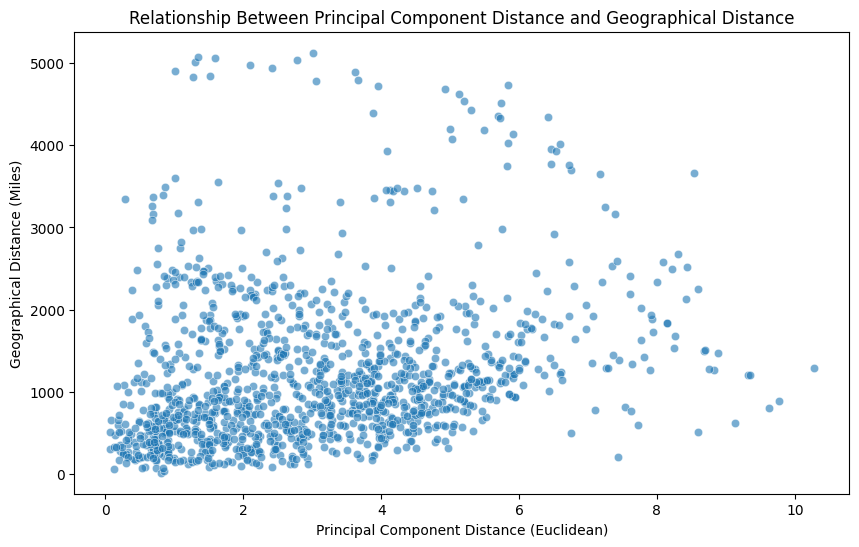

In [98]:
# Plotting
plt.figure(figsize=(10, 6))
sns.scatterplot(data=plot_data, x='PC Distance', y='Geographical Distance', alpha=0.6)
plt.title('Relationship Between Principal Component Distance and Geographical Distance')
plt.xlabel('Principal Component Distance (Euclidean)')
plt.ylabel('Geographical Distance (Miles)')
plt.show()

### Insights


Proximity in Geographical Distance and Principal Components:
* States that are geographically closer tend to have similar principal component scores. This might reflect shared characteristics or patterns in the dataset, such as similar COVID-19 case rates or vaccination trends, which align with geographical proximity.
For example, states that are geographically close might have similar population densities, healthcare systems, or public health policies, which could influence both the geographical distance and the principal component scores.